# Generate Sentinel-2 Composites for Parcelization Detection (2019 vs 2025)

**Author:** Dr. Mark Stone  
**Date:** 2025-10-19  
**Purpose:** Generate cloud-free Sentinel-2 median composites for 2019 and 2025 to identify new parcelization in Los Lagos region

---

## 📋 Overview

This notebook creates high-quality Sentinel-2 RGB composites for two time periods (2019 and 2025) to support:
1. **Visual identification** of new parcelization in QGIS
2. **Training data digitization** with temporal context
3. **Change detection** between time periods

### Why 2019 vs 2025?

- **2019**: Baseline period before recent parcelization surge
- **2025**: Current state showing recent subdivision activity
- **6-year gap**: Sufficient time to detect land-use change while maintaining imagery quality

### Outputs

1. **Earth Engine Assets**: Full-resolution composites for analysis
2. **Local Thumbnails**: Quick-view PNG images for reference
3. **Quality Metrics**: Scene counts, cloud statistics, coverage assessment
4. **Change Preview**: Simple difference visualization

---

# 1. Setup and Initialization

**Objective:**  
Import libraries, initialize Earth Engine, and configure project paths.

**Key Components:**
- Earth Engine authentication and initialization
- Project directory structure
- Output folder creation

In [22]:
# 1) Setup and Initialization

import ee
import json
import os
from pathlib import Path
from urllib.request import urlretrieve
from datetime import datetime
import pandas as pd

# Optional: For visualization in notebook
try:
    import geemap
    import matplotlib.pyplot as plt
    from PIL import Image
    VISUALIZATION_AVAILABLE = True
except ImportError:
    VISUALIZATION_AVAILABLE = False
    print('⚠️  geemap/matplotlib not available. Visualization disabled.')

# === Initialize Earth Engine ===
try:
    ee.Initialize()
    print('✓ Earth Engine initialized')
except Exception as e:
    print('❌ Earth Engine initialization failed')
    print('   Attempting authentication...')
    ee.Authenticate()
    ee.Initialize()
    print('✓ Earth Engine initialized after authentication')

# === Configure Project Paths (repo-root detection) ===
THIS_NOTEBOOK = Path(__file__).resolve() if "__file__" in globals() else Path.cwd()
repo_root = None
for parent in [THIS_NOTEBOOK] + list(THIS_NOTEBOOK.parents):
    if (parent / 'README.md').exists() and (parent / 'data').exists():
        repo_root = parent
        break
if repo_root is None:
    repo_root = THIS_NOTEBOOK

PROJECT_ROOT = repo_root

# Define key paths (within this repo)
AOI_PATH = PROJECT_ROOT / 'data' / 'external' / 'aoi.geojson'
THUMB_DIR = PROJECT_ROOT / 'data' / 'thumbnails'
REPORTS_DIR = PROJECT_ROOT / 'reports'

# Create output directories
THUMB_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

print(f'\n📁 Project Structure:')
print(f'   Root: {PROJECT_ROOT}')
print(f'   AOI: {AOI_PATH}')
print(f'   Thumbnails: {THUMB_DIR}')
print(f'   Reports: {REPORTS_DIR}')
print(f'\n   AOI exists: {AOI_PATH.exists()}')

if not AOI_PATH.exists():
    print('\n❌ AOI file not found! Please check the path.')
    print('   Expected location:', AOI_PATH)

✓ Earth Engine initialized

📁 Project Structure:
   Root: /Users/mstone14/QGIS/GeoAI_Class/github/earth-vision-portfolio
   AOI: /Users/mstone14/QGIS/GeoAI_Class/github/earth-vision-portfolio/data/external/aoi.geojson
   Thumbnails: /Users/mstone14/QGIS/GeoAI_Class/github/earth-vision-portfolio/data/thumbnails
   Reports: /Users/mstone14/QGIS/GeoAI_Class/github/earth-vision-portfolio/reports

   AOI exists: True


**Outcome:**

After running this cell:
- ✓ Earth Engine connection established
- ✓ Project directories created
- ✓ AOI file location verified

If AOI exists shows `False`, update the `PROJECT_ROOT` path to match your system.

---

# 2. Load and Validate AOI

**Objective:**  
Load the Area of Interest GeoJSON and convert to Earth Engine geometry.

**Validation checks:**
- File is readable
- Valid GeoJSON structure
- Geometry is within expected region (Chile)
- Area is reasonable size

In [25]:
# 2) Load and Validate AOI

# Robust GeoJSON loader (FeatureCollection, Feature, or Geometry)
def _load_aoi_geometry(path: Path):
    with open(path, 'r') as f:
        gj = json.load(f)
    gj_type = gj.get('type', None)
    if gj_type == 'FeatureCollection':
        feats = gj.get('features', [])
        if not feats:
            raise ValueError('AOI FeatureCollection has no features')
        return feats[0]['geometry']
    if gj_type == 'Feature':
        return gj['geometry']
    # Raw geometry
    if 'coordinates' in gj and isinstance(gj.get('type'), str):
        if gj['type'] == 'GeometryCollection':
            geoms = gj.get('geometries', [])
            if not geoms:
                raise ValueError('Empty GeometryCollection')
            return geoms[0]
        return gj
    raise ValueError('Unsupported AOI GeoJSON format')

# Load and convert to Earth Engine geometry
aoi_geometry = _load_aoi_geometry(AOI_PATH)
AOI_EE = ee.Geometry(aoi_geometry)

print('✓ AOI loaded successfully')

# === Validation: Check bounds ===
bounds = AOI_EE.bounds(1).getInfo()['coordinates'][0]
lons = [coord[0] for coord in bounds]
lats = [coord[1] for coord in bounds]

min_lon, max_lon = min(lons), max(lons)
min_lat, max_lat = min(lats), max(lats)

print(f'\n📍 AOI Bounds:')
print(f'   Longitude: {min_lon:.4f} to {max_lon:.4f}')
print(f'   Latitude: {min_lat:.4f} to {max_lat:.4f}')

# Check if in Los Lagos region (approximately)
expected_lon_range = (-73.5, -71.5)  # Los Lagos longitude
expected_lat_range = (-42.5, -39.5)  # Los Lagos latitude

if (expected_lon_range[0] <= min_lon <= expected_lon_range[1] and
    expected_lat_range[0] <= min_lat <= expected_lat_range[1]):
    print('✓ AOI is in Los Lagos region')
else:
    print('⚠️  AOI may not be in Los Lagos region. Please verify.')

# === Calculate area ===
area_m2 = AOI_EE.area(maxError=1).getInfo()
area_km2 = area_m2 / 1e6

print(f'\n📐 AOI Area: {area_km2:.2f} km²')

if area_km2 < 1:
    print('⚠️  Very small AOI (<1 km²). Consider expanding for better analysis.')
elif area_km2 > 10000:
    print('⚠️  Very large AOI (>10,000 km²). Processing may be slow.')
else:
    print('✓ AOI size is reasonable')

# === Optional: Visualize AOI ===
if VISUALIZATION_AVAILABLE:
    Map = geemap.Map()
    Map.centerObject(AOI_EE, zoom=10)
    Map.addLayer(AOI_EE, {'color': 'red'}, 'AOI')
    display(Map)
else:
    print('\n💡 Install geemap to visualize AOI: pip install geemap')

✓ AOI loaded successfully

📍 AOI Bounds:
   Longitude: -73.1071 to -73.0067
   Latitude: -41.1507 to -41.0913
✓ AOI is in Los Lagos region

📐 AOI Area: 55.64 km²
✓ AOI size is reasonable


Map(center=[-41.12099664217866, -73.056936000002], controls=(WidgetControl(options=['position', 'transparent_b…

**Outcome:**

- ✓ AOI geometry loaded and validated
- 📍 Bounds confirmed in Los Lagos region
- 📐 Area calculated and checked
- 🗺️ Interactive map displayed (if geemap available)

If any warnings appear, review your AOI before proceeding.

---

# 3. Configure Composite Parameters

**Objective:**  
Define parameters for composite generation including time periods, cloud filtering, and export settings.

**Key Parameters:**
- **Years**: 2019 and 2024
- **Cloud threshold**: Maximum acceptable cloud percentage
- **Scale**: Spatial resolution (10m for Sentinel-2 RGB)
- **CRS**: Coordinate reference system (UTM Zone 18S for Los Lagos)
- **Export location**: Your Earth Engine asset folder

In [26]:
# 3) Configure Composite Parameters

# === Temporal Parameters ===
YEARS = [2019, 2025]

# Austral growing seasons (expanded shoulder months)
DATE_RANGES = {
    2019: ('2018-10-01', '2019-04-30'),
    2025: ('2024-10-01', '2025-04-30')
}

# === Quality Parameters ===
CLOUD_THRESHOLD = 30  # Maximum cloud percentage per scene

# === Export Parameters ===
SCALE = 10            # Meters per pixel (Sentinel-2 native 10 m for RGB/NIR)
CRS = None            # Use native CRS; do not force EPSG
MAX_PIXELS = 1e13     # Maximum pixels for export

# === Earth Engine Asset Location ===
# IMPORTANT: Update this to your Earth Engine username!
EE_USERNAME = 'markstonegobigred'  # Replace with your EE username
TARGET_FOLDER = f'users/{EE_USERNAME}/Parcela'

print('📅 Composite Configuration:')
print('=' * 60)
for year in YEARS:
    start, end = DATE_RANGES[year]
    print(f'\n{year}:')
    print(f'   Date range: {start} → {end}')
    print(f'   Season: Austral growing season (expanded)')
print(f'\n☁️  Cloud threshold: ≤{CLOUD_THRESHOLD}%')
print(f'📐 Spatial resolution: {SCALE}m')
print(f'🗺️  CRS: native (not forced)')
print(f'📁 Export folder: {TARGET_FOLDER}')
print('=' * 60)

# === Create processing log ===
processing_log = {
    'timestamp': datetime.now().isoformat(),
    'aoi_area_km2': area_km2,
    'years': YEARS,
    'date_ranges': DATE_RANGES,
    'cloud_threshold': CLOUD_THRESHOLD,
    'scale': SCALE,
    'crs': 'native',
    'target_folder': TARGET_FOLDER,
    'composites': {}
}

📅 Composite Configuration:

2019:
   Date range: 2018-10-01 → 2019-04-30
   Season: Austral growing season (expanded)

2025:
   Date range: 2024-10-01 → 2025-04-30
   Season: Austral growing season (expanded)

☁️  Cloud threshold: ≤30%
📐 Spatial resolution: 10m
🗺️  CRS: native (not forced)
📁 Export folder: users/markstonegobigred/Parcela


**Outcome:**

Configuration complete:
- 📅 Time periods defined (austral summer for each year)
- ☁️ Cloud filtering set to ≤20%
- 📐 Resolution: 10m (native Sentinel-2 RGB)
- 📁 Export location configured

**⚠️ Important:** Make sure to update `EE_USERNAME` to match your Earth Engine account!

---

# 4. Define Cloud Masking Function

**Objective:**  
Create a function to mask clouds and cloud shadows using Sentinel-2's QA60 band.

**How it works:**
- **QA60 band**: Contains cloud probability information
- **Bit 10**: Opaque clouds
- **Bit 11**: Cirrus clouds
- We mask pixels where either bit is set (cloud present)

In [27]:
# 4) Cloud/shadow masking (s2cloudless + SCL shadows) and band prep

CLOUD_PROB_THRESHOLD = 60  # 0-100 probability


def mask_clouds_and_shadows(image):
    """Mask clouds using s2cloudless probability and shadows using SCL classes.
    - Clouds: cloud_prob < threshold retained (i.e., mask high probability)
    - Shadows: mask SCL = 3 (cloud shadow), and mask cloud classes 8, 9, 10
    """
    # Cloud probability band added via join later (band 'cloud_prob')
    cloud_clear = image.select('cloud_prob').lt(CLOUD_PROB_THRESHOLD)
    scl = image.select('SCL')
    no_shadows = scl.neq(3)
    no_cloud_classes = scl.neq(8).And(scl.neq(9)).And(scl.neq(10))
    mask = cloud_clear.And(no_shadows).And(no_cloud_classes)
    return image.updateMask(mask)


def prepare_six_bands(image):
    """Select RGB+NIR+SWIR and upsample 20 m bands to 10 m via bilinear."""
    bands10 = ['B2', 'B3', 'B4', 'B8']
    bands20 = ['B11', 'B12']
    b10 = image.select(bands10)
    b20 = image.select(bands20).resample('bilinear')
    out = b10.addBands(b20).toFloat()
    return out

print('✓ Cloud/shadow mask and band prep functions defined')

✓ Cloud/shadow mask and band prep functions defined


**Outcome:**

Cloud masking function ready. This will be applied to all Sentinel-2 scenes before creating the median composite.

**Why median composite?**
- Reduces noise from individual scenes
- Fills cloud gaps by using clear pixels from multiple dates
- More robust than single-date imagery
- Represents typical conditions for the time period

---

# 5. Generate Composites and Export to Earth Engine Assets

**Objective:**  
For each year (2018, 2024):
1. Filter Sentinel-2 collection by date and cloud cover
2. Apply cloud masking
3. Create median composite
4. Export to Earth Engine asset
5. Generate local thumbnail
6. Collect quality metrics

**This cell will:**
- Submit export tasks to Earth Engine (run in background)
- Download thumbnail previews immediately
- Report scene counts and quality statistics

In [28]:
# 5) Generate Composites and Export

# Helper: add s2cloudless probability via join
s2_sr = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
s2_cloudless = ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')

# Join collections by system:index
join_filter = ee.Filter.equals(leftField='system:index', rightField='system:index')
save_join = ee.Join.saveFirst(matchKey='cloud_props')


def add_cloud_prob(img):
    matched = ee.Image(img.get('cloud_props'))
    return img.addBands(matched.select('probability').rename('cloud_prob'))


def generate_composite(year):
    start_date, end_date = DATE_RANGES[year]
    asset_name = f's2_{year}_median_6b'
    asset_id = f'{TARGET_FOLDER}/{asset_name}'
    
    print(f'\n{"=" * 60}')
    print(f'Processing {year}')
    print(f'{"=" * 60}')
    print(f'Date range: {start_date} → {end_date}')
    
    # Filter collections
    s2 = (s2_sr
          .filterBounds(AOI_EE)
          .filterDate(start_date, end_date)
          .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', CLOUD_THRESHOLD)))
    s2p = (s2_cloudless
           .filterBounds(AOI_EE)
           .filterDate(start_date, end_date))

    # Perform join and add cloud prob
    joined = save_join.apply(s2, s2p, join_filter)
    with_prob = ee.ImageCollection(joined).map(add_cloud_prob)

    # Mask clouds and shadows, prep bands
    processed = (with_prob
                 .map(mask_clouds_and_shadows)
                 .map(prepare_six_bands))

    # Composite
    composite = processed.median().clip(AOI_EE)

    # Export to asset (no forced CRS)
    export_image = composite
    try:
        # Delete existing asset if overwrite desired
        ee.data.deleteAsset(asset_id)
        print(f'Overwrote existing asset: {asset_id}')
    except Exception:
        pass

    task = ee.batch.Export.image.toAsset(
        image=export_image,
        description=asset_name,
        assetId=asset_id,
        region=AOI_EE,
        scale=SCALE,
        maxPixels=MAX_PIXELS
    )
    task.start()
    print(f'Export started: {asset_id}')

    # Thumbnail of RGB for quick look
    rgb_vis = {'min': 0, 'max': 3000, 'bands': ['B4','B3','B2']}
    thumb_url = export_image.visualize(**rgb_vis).getThumbURL({'dimensions': 1024, 'region': AOI_EE})
    thumb_path = THUMB_DIR / f's2_{year}_thumbnail.png'
    urlretrieve(thumb_url, thumb_path)
    print(f'Thumbnail saved: {thumb_path}')

    band_names = export_image.bandNames().getInfo()
    return asset_id, {'year': year, 'scene_count': s2.size().getInfo(), 'asset_id': asset_id, 'bands': band_names}

# Ensure folder exists
print('Checking EE folder...')
try:
    user_root = f'users/{EE_USERNAME}'
    assets = ee.data.listAssets({'parent': user_root})
    folders = [a['name'] for a in assets.get('assets', []) if a.get('type') == 'FOLDER']
    if TARGET_FOLDER not in folders:
        ee.data.createAsset({'type': 'Folder'}, TARGET_FOLDER)
        print(f'Created folder: {TARGET_FOLDER}')
    else:
        print(f'Folder exists: {TARGET_FOLDER}')
except Exception as e:
    print(f'Warning: {e}')

# Process each season-end year
asset_list = []
metrics_list = []
for year in YEARS:
    asset_id, metrics = generate_composite(year)
    if asset_id:
        asset_list.append(asset_id)
        metrics_list.append(metrics)
        processing_log['composites'][year] = metrics

print(f'\n✅ Tasks submitted. Monitor at: https://code.earthengine.google.com/tasks')
print(f'Assets: {asset_list}')

Checking EE folder...

Processing 2019
Date range: 2018-10-01 → 2019-04-30
Export started: users/markstonegobigred/Parcela/s2_2019_median_6b
Thumbnail saved: /Users/mstone14/QGIS/GeoAI_Class/github/earth-vision-portfolio/data/thumbnails/s2_2019_thumbnail.png

Processing 2025
Date range: 2024-10-01 → 2025-04-30
Export started: users/markstonegobigred/Parcela/s2_2025_median_6b
Thumbnail saved: /Users/mstone14/QGIS/GeoAI_Class/github/earth-vision-portfolio/data/thumbnails/s2_2025_thumbnail.png

✅ Tasks submitted. Monitor at: https://code.earthengine.google.com/tasks
Assets: ['users/markstonegobigred/Parcela/s2_2019_median_6b', 'users/markstonegobigred/Parcela/s2_2025_median_6b']


**Outcome:** Export tasks submitted to Earth Engine. Thumbnails downloaded locally. Monitor progress in EE Tasks tab.

---

# 6. Visualize Thumbnails

**Objective:** Display thumbnails side-by-side for visual comparison.

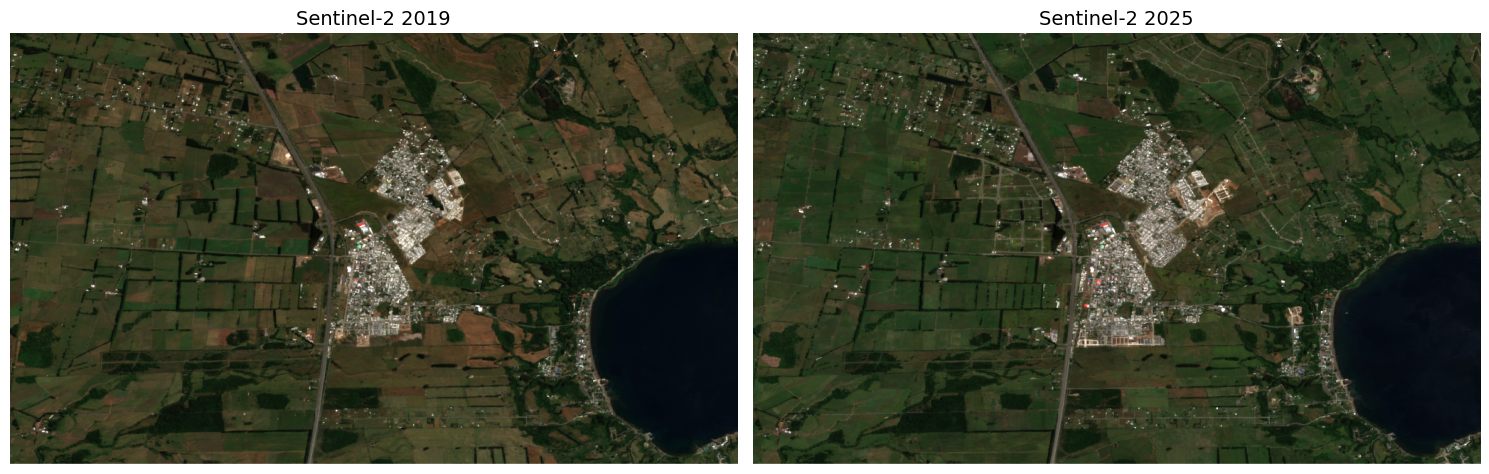

Comparison saved

Metrics:
 year  scene_count                                          asset_id                      bands
 2019           10 users/markstonegobigred/Parcela/s2_2019_median_6b [B2, B3, B4, B8, B11, B12]
 2025           12 users/markstonegobigred/Parcela/s2_2025_median_6b [B2, B3, B4, B8, B11, B12]
Metrics saved to CSV


In [29]:
# 6) Visualize Thumbnails

if VISUALIZATION_AVAILABLE:
    fig, axes = plt.subplots(1, len(YEARS), figsize=(15, 7))
    if len(YEARS) == 1:
        axes = [axes]
    for idx, year in enumerate(YEARS):
        thumb_path = THUMB_DIR / f's2_{year}_thumbnail.png'
        if thumb_path.exists():
            img = Image.open(thumb_path)
            axes[idx].imshow(img)
            axes[idx].set_title(f'Sentinel-2 {year}', fontsize=14)
            axes[idx].axis('off')
    plt.tight_layout()
    plt.savefig(REPORTS_DIR / 'composite_comparison.png', dpi=150)
    plt.show()
    print('Comparison saved')
else:
    print('Thumbnails saved to:', THUMB_DIR)

if metrics_list:
    df = pd.DataFrame(metrics_list)
    print('\nMetrics:')
    print(df.to_string(index=False))
    df.to_csv(REPORTS_DIR / 'composite_metrics.csv', index=False)
    print('Metrics saved to CSV')

---

# 7. QGIS Integration Guide

## Loading Composites in QGIS

### Using GEE Plugin:

```python
import ee
from ee_plugin import Map

ee.Initialize()

composite_2018 = ee.Image('users/YOUR_USERNAME/Parcela/s2_2018_median')
Map.addLayer(composite_2018, {'min': 0, 'max': 3000, 'bands': ['B4','B3','B2']}, 'S2 2018')

composite_2024 = ee.Image('users/YOUR_USERNAME/Parcela/s2_2024_median')
Map.addLayer(composite_2024, {'min': 0, 'max': 3000, 'bands': ['B4','B3','B2']}, 'S2 2024')
```

### Tips for Identifying Parcelization:
- Look for grid patterns
- New roads and clearings
- Small regular subdivisions
- Mixed land cover (structures + vegetation)
- Compare 2018 vs 2024 to identify new development

---

# 8. Save Processing Log

In [30]:
# 8) Save Processing Log

log_path = REPORTS_DIR / 'composite_processing_log.json'
with open(log_path, 'w') as f:
    json.dump(processing_log, f, indent=2)

print(f'✓ Log saved: {log_path}')
print(f'\n✅ Complete!')
print(f'\nOutputs:')
print(f'  Thumbnails: {THUMB_DIR}')
print(f'  Metrics: {REPORTS_DIR / "composite_metrics.csv"}')
print(f'  Log: {log_path}')
print(f'\nEE Assets:')
for asset in asset_list:
    print(f'  {asset}')
print(f'\nNext: Load composites in QGIS and begin digitizing training polygons!')

✓ Log saved: /Users/mstone14/QGIS/GeoAI_Class/github/earth-vision-portfolio/reports/composite_processing_log.json

✅ Complete!

Outputs:
  Thumbnails: /Users/mstone14/QGIS/GeoAI_Class/github/earth-vision-portfolio/data/thumbnails
  Metrics: /Users/mstone14/QGIS/GeoAI_Class/github/earth-vision-portfolio/reports/composite_metrics.csv
  Log: /Users/mstone14/QGIS/GeoAI_Class/github/earth-vision-portfolio/reports/composite_processing_log.json

EE Assets:
  users/markstonegobigred/Parcela/s2_2019_median_6b
  users/markstonegobigred/Parcela/s2_2025_median_6b

Next: Load composites in QGIS and begin digitizing training polygons!
